<a href="https://colab.research.google.com/github/sanjeev12-09/California-housing-prediction-withSGDRegressor/blob/main/Sgd_regressor_(MLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import SGDRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
np.random.seed(306)

In [3]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size= 0.2, random_state=0)

# Load the data and split into train and test

In [4]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)

Divide the data into train and dev state

In [5]:
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

# Baseline SGDRegressor 

In [6]:
sgd = SGDRegressor(random_state=42)
sgd.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd.predict(dev_features))
print("Mean absolute error on training set", train_mae)
print("Mean absolute error on development set", dev_mae)

Mean absolute error on training set 312995824045833.75
Mean absolute error on development set 315394681503071.94


We can observe that the error is very high. The baseline model doesnot train well. This may happen due to large learning rate. Lets investigate the model step by step and investigate the issuue.

# Adding a feature scaling step

In [7]:
sgd_pipeline = Pipeline([("feature scaling", StandardScaler()),
                         ("sgd", SGDRegressor())])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print("Mean absolute error on training set", train_mae)
print("Mean absolute error on development set", dev_mae)

Mean absolute error on training set 0.5135804404077051
Mean absolute error on development set 0.6373131245753217


The error is still high . Lets run sgd regressor step by step

# Step wise training SGDRegressor

Text(0.5, 1.0, 'Learning curve: eta0 = 0.0100')

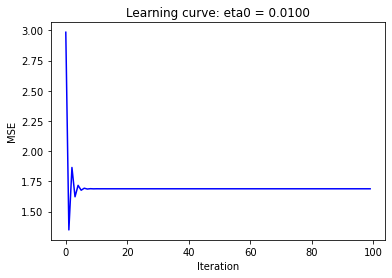

In [8]:
eta0 = 1e-2
sgd_pipeline = Pipeline([("feature scaling", StandardScaler()),
                         ("SGD", SGDRegressor(max_iter = 1, tol= -np.infty, warm_start= True, random_state=42))])

loss=[]
for epoch in range(100):
  sgd_pipeline.fit(train_features, train_labels)
  loss.append(mean_squared_error(train_labels, sgd_pipeline.predict(train_features)
                                 ))
  
plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration')
plt.ylabel("MSE")
plt.title(f"Learning curve: eta0 = {eta0:.4f}")

The loss reduce initialy and then increased due to large learning rate. Now we reduce the learning rate by 10 and retry the training

Text(0.5, 1.0, 'Learning curve: eta0 = 0.0010')

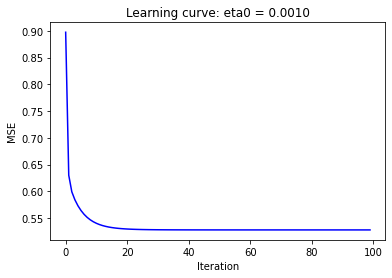

In [9]:
eta0 = 1e-3
sgd_pipeline = Pipeline([("feature scaling", StandardScaler()),
                         ("SGD", SGDRegressor(max_iter = 1, tol= -np.infty, warm_start= True,eta0 = eta0, random_state=42))])

loss=[]
for epoch in range(100):
  sgd_pipeline.fit(train_features, train_labels)
  loss.append(mean_squared_error(train_labels, sgd_pipeline.predict(train_features)
                                 ))
  
plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration')
plt.ylabel("MSE")
plt.title(f"Learning curve: eta0 = {eta0:.4f}")

This is an ideal learning curve where the train loss reduce monotonically

In [10]:
print("no. of iteration before reaches convergence criteria :",
        sgd_pipeline[-1].n_iter_)
print("no. of weight updates", sgd_pipeline[-1].t_)

no. of iteration before reaches convergence criteria : 1
no. of weight updates 11611.0


In [11]:
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print("Mean absolute error on training set", train_mae)
print("Mean absolute error on development set", dev_mae)

Mean absolute error on training set 0.5333732983042573
Mean absolute error on development set 0.5190150280908042


# Fixing learning rate through learning curves

In [12]:
%%time
eta0 = [1e-5, 1e-4, 1e-3, 1e-2 ]
train_scores, test_scores = validation_curve(
    sgd_pipeline, com_train_features, com_train_labels, param_name="SGD__eta0",
    param_range = eta0, cv = shuffle_split_cv, scoring = "neg_mean_squared_error", n_jobs = 2)
train_errors, test_errors = -train_scores, -test_scores

CPU times: user 309 ms, sys: 67.6 ms, total: 377 ms
Wall time: 1.91 s


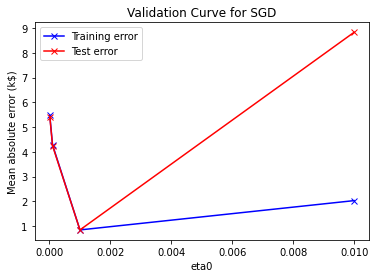

In [13]:
train_errors, test_errors = -train_scores, -test_scores
plt.plot(eta0, train_errors.mean(axis=1),'b-x', label = 'Training error')
plt.plot(eta0, test_errors.mean(axis=1),'r-x', label = 'Test error')
plt.legend()
plt.xlabel('eta0')
plt.ylabel("Mean absolute error (k$)")
_=plt.title("Validation Curve for SGD")

For eta0 = 1e-3 , the test error is least and hence we select the value as the value for eta0

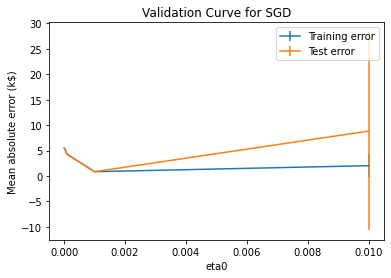

In [14]:

plt.errorbar(eta0, train_errors.mean(axis=1),yerr=train_errors.std(axis=1), label = 'Training error')
plt.errorbar(eta0, test_errors.mean(axis=1),yerr=test_errors.std(axis=1), label = 'Test error')
plt.legend()
plt.xlabel('eta0')
plt.ylabel("Mean absolute error (k$)")
_=plt.title("Validation Curve for SGD")

# SGD Regressor

In [15]:
sgd_pipeline = Pipeline([("feature scaling", StandardScaler()),
                         ("SGD", SGDRegressor(max_iter = 500, 
                                              early_stopping= True,eta0 = 1e-3,
                                              tol= 1e-3,validation_fraction = 0.2,
                                              n_iter_no_change =5, average=10, random_state=42))])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print("Mean absolute error on training set", train_mae)
print("Mean absolute error on development set", dev_mae)

Mean absolute error on training set 0.579376454514559
Mean absolute error on development set 0.5689180241137523


In [16]:
print("no. of iteration before reaches convergence criteria :",
        sgd_pipeline[-1].n_iter_)
print("no. of weight updates", sgd_pipeline[-1].t_)

no. of iteration before reaches convergence criteria : 7
no. of weight updates 81271.0


In [19]:
sgd_pipeline = Pipeline([("feature scaling", StandardScaler()),
                         ("SGD", SGDRegressor(max_iter = 500, 
                                              early_stopping= True,eta0 = 1e-3,
                                              tol= 1e-3,learning_rate = 'constant',
                                              validation_fraction = 0.2,
                                              n_iter_no_change =5, average=10, random_state=42))])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print("Mean absolute error on training set", train_mae)
print("Mean absolute error on development set", dev_mae)

print("\n no. of iteration before reaches convergence criteria :",
        sgd_pipeline[-1].n_iter_)
print("no. of weight updates", sgd_pipeline[-1].t_)

Mean absolute error on training set 0.5359339681114987
Mean absolute error on development set 0.5151099728924144

 no. of iteration before reaches convergence criteria : 8
no. of weight updates 92881.0


In [20]:
sgd_pipeline = Pipeline([("feature scaling", StandardScaler()),
                         ("SGD", SGDRegressor(max_iter = 500, 
                                              early_stopping= True,eta0 = 1e-3,
                                              tol= 1e-3,learning_rate = 'adaptive',
                                              validation_fraction = 0.2,
                                              n_iter_no_change =5, average=10, random_state=42))])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print("Mean absolute error on training set", train_mae)
print("Mean absolute error on development set", dev_mae)

print("\n no. of iteration before reaches convergence criteria :",
        sgd_pipeline[-1].n_iter_)
print(" no. of weight updates", sgd_pipeline[-1].t_)

Mean absolute error on training set 0.5340193046836148
Mean absolute error on development set 0.5198356196858102

 no. of iteration before reaches convergence criteria : 33
 no. of weight updates 383131.0


# Setting max_iters

In [21]:
max_iter = np.ceil(1e6/com_train_features.shape[0])
max_iter

65.0

In [23]:
sgd_pipeline = Pipeline([("feature scaling", StandardScaler()),
                         ("SGD", SGDRegressor(max_iter = max_iter, 
                                              early_stopping= True,eta0 = 1e-3,
                                              tol= 1e-3,learning_rate = 'constant',
                                              validation_fraction = 0.2,
                                              n_iter_no_change =5, average=10, random_state=42))])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print("Mean absolute error on training set", train_mae)
print("Mean absolute error on development set", dev_mae)

print("\n no. of iteration before reaches convergence criteria :",
        sgd_pipeline[-1].n_iter_)
print(" no. of weight updates", sgd_pipeline[-1].t_)

Mean absolute error on training set 0.5359339681114987
Mean absolute error on development set 0.5151099728924144

 no. of iteration before reaches convergence criteria : 8
 no. of weight updates 92881.0
